In [75]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Librerías importadas exitosamente")


Librerías importadas exitosamente


In [76]:
# Cargar los datos
df = pd.read_csv('../data/processed/combined_dataset.csv')

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Información básica del dataset
print("\n" + "="*50)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("PRIMERAS 10 FILAS")
print("="*50)
display(df.head(10))

print("\n" + "="*50)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
display(df.describe())


Dataset cargado exitosamente!
Dimensiones del dataset: (38456, 7)
Memoria utilizada: 3.83 MB

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38456 entries, 0 to 38455
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           38456 non-null  int64  
 1   landmark_index  38456 non-null  int64  
 2   x               38456 non-null  float64
 3   y               38456 non-null  float64
 4   z               38456 non-null  float64
 5   visibility      38456 non-null  float64
 6   movement        38456 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 2.1+ MB
None

PRIMERAS 10 FILAS


,frame,landmark_index,x,y,z,visibility,movement
0,1,0,0.4712,0.1188,0.1986,1.0000,girar
1,1,11,0.3954,0.2537,-0.0036,0.9999,girar
2,1,12,0.5295,0.2481,0.0263,0.9999,girar
3,1,23,0.4293,0.6080,-0.0403,0.9992,girar
4,1,24,0.5095,0.5984,0.0397,0.9988,girar
5,1,25,0.4236,0.8574,-0.0526,0.8306,girar
6,1,26,0.5005,0.8476,0.0533,0.7148,girar
7,2,0,0.4696,0.1194,0.0651,0.9999,girar
8,2,11,0.3949,0.2531,-0.1725,0.9999,girar
9,2,12,0.5302,0.2471,-0.1007,0.9999,girar



ESTADÍSTICAS DESCRIPTIVAS


,frame,landmark_index,x,y,z,visibility
count,38456.0000,38456.0000,38456.0000,38456.0000,38456.0000,38456.0000
mean,50.5225,17.0291,0.5028,0.5972,-0.0494,0.9229
std,32.9688,9.4941,0.0718,0.2810,0.1821,0.1372
min,0.0000,0.0000,0.2004,-1.0758,-1.2767,0.5001
25%,24.0000,11.0000,0.4511,0.3910,-0.1221,0.9183
50%,47.0000,23.0000,0.5024,0.6296,-0.0394,0.9967
75%,72.0000,25.0000,0.5493,0.8400,0.0287,0.9994
max,169.0000,32.0000,1.0438,1.9233,1.5684,1.0000


In [77]:
# Verificar valores nulos y duplicados
print("ANÁLISIS DE CALIDAD DE DATOS")
print("="*50)

print("Valores nulos por columna:")
null_counts = df.isnull().sum()
for col, count in null_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {col}: {count} ({percentage:.2f}%)")

print(f"\nFilas duplicadas: {df.duplicated().sum()}")

# Verificar tipos de datos
print(f"\nTipos de datos:")
for col, dtype in df.dtypes.items():
    print(f"  {col}: {dtype}")

# Rango de valores para coordenadas
print(f"\nRangos de coordenadas:")
for coord in ['x', 'y', 'z']:
    min_val = df[coord].min()
    max_val = df[coord].max()
    print(f"  {coord}: [{min_val:.4f}, {max_val:.4f}]")

# Rango de visibility
print(f"\nRango de visibility: [{df['visibility'].min():.4f}, {df['visibility'].max():.4f}]")


ANÁLISIS DE CALIDAD DE DATOS
Valores nulos por columna:
  frame: 0 (0.00%)
  landmark_index: 0 (0.00%)
  x: 0 (0.00%)
  y: 0 (0.00%)
  z: 0 (0.00%)
  visibility: 0 (0.00%)
  movement: 0 (0.00%)

Filas duplicadas: 0

Tipos de datos:
  frame: int64
  landmark_index: int64
  x: float64
  y: float64
  z: float64
  visibility: float64
  movement: object

Rangos de coordenadas:
  x: [0.2004, 1.0438]
  y: [-1.0758, 1.9233]
  z: [-1.2767, 1.5684]

Rango de visibility: [0.5001, 1.0000]


In [78]:
# Análisis de distribución de movimientos
print("ANÁLISIS DE DISTRIBUCIÓN DE MOVIMIENTOS")
print("="*50)

# Conteo de cada movimiento
movement_counts = df['movement'].value_counts()
movement_percentages = df['movement'].value_counts(normalize=True) * 100

print("Distribución de movimientos:")
for movement, count in movement_counts.items():
    percentage = movement_percentages[movement]
    print(f"  {movement}: {count:,} landmarks ({percentage:.2f}%)")

print(f"\nTotal de landmarks: {len(df):,}")
print(f"Número de clases: {df['movement'].nunique()}")

# Calcular balance del dataset
min_samples = movement_counts.min()
max_samples = movement_counts.max()
balance_ratio = min_samples / max_samples
print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")

if balance_ratio >= 0.8:
    print("✅ Dataset bien balanceado")
elif balance_ratio >= 0.5:
    print("⚠️ Dataset moderadamente balanceado")
else:
    print("❌ Dataset desbalanceado - considerar técnicas de balanceo")


ANÁLISIS DE DISTRIBUCIÓN DE MOVIMIENTOS
Distribución de movimientos:
  girar: 9,873 landmarks (25.67%)
  sentar: 9,429 landmarks (24.52%)
  ir al frente: 7,528 landmarks (19.58%)
  parar: 6,321 landmarks (16.44%)
  devolverse: 5,305 landmarks (13.79%)

Total de landmarks: 38,456
Número de clases: 5

Ratio de balance (min/max): 0.537
⚠️ Dataset moderadamente balanceado


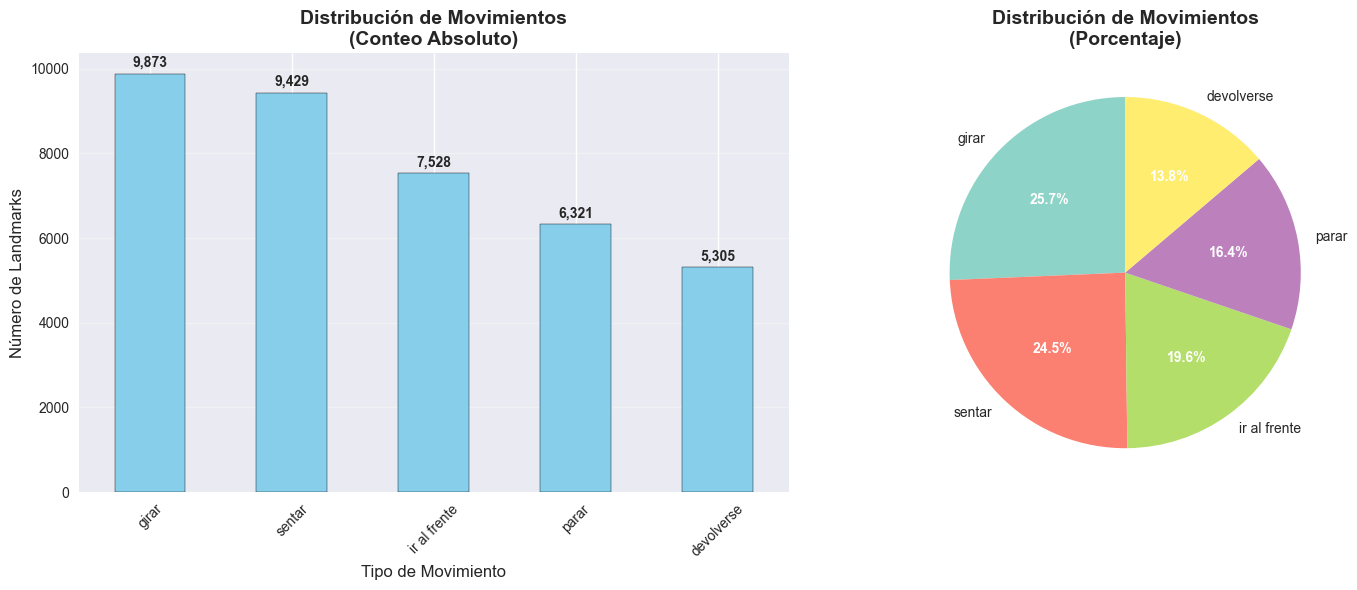

In [79]:
# Visualización de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
movement_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Movimientos\n(Conteo Absoluto)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0].set_ylabel('Número de Landmarks', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(movement_counts.values):
    axes[0].text(i, v + max(movement_counts)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
colors = plt.cm.Set3(np.linspace(0, 1, len(movement_counts)))
wedges, texts, autotexts = axes[1].pie(movement_counts.values, 
                                      labels=movement_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Distribución de Movimientos\n(Porcentaje)', fontsize=14, fontweight='bold')

# Mejorar la apariencia del gráfico de pastel
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()


In [80]:
# Análisis de landmarks incluidos
print("ANÁLISIS DE LANDMARKS")
print("="*50)

# Mapeo de nombres de landmarks según MediaPipe
landmark_names = {
    0: "Nariz",
    11: "Hombro Izquierdo", 
    12: "Hombro Derecho",
    23: "Cadera Izquierda", 
    24: "Cadera Derecha",
    25: "Rodilla Izquierda", 
    26: "Rodilla Derecha",
    27: "Tobillo Izquierdo", 
    28: "Tobillo Derecho",
    31: "Pie Izquierdo", 
    32: "Pie Derecho"
}

# Conteo de landmarks
landmark_counts = df['landmark_index'].value_counts().sort_index()

print("Landmarks incluidos en el dataset:")
print("-" * 40)
for landmark_idx, count in landmark_counts.items():
    name = landmark_names.get(landmark_idx, f"Landmark {landmark_idx}")
    percentage = (count / len(df)) * 100
    print(f"  {landmark_idx:2d} - {name:20s}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal de landmarks únicos: {df['landmark_index'].nunique()}")

# Verificar si hay landmarks faltantes
expected_landmarks = set(landmark_names.keys())
actual_landmarks = set(df['landmark_index'].unique())
missing_landmarks = expected_landmarks - actual_landmarks

if missing_landmarks:
    print(f"\n⚠️ Landmarks faltantes: {missing_landmarks}")
else:
    print("\n✅ Todos los landmarks esperados están presentes")


ANÁLISIS DE LANDMARKS
Landmarks incluidos en el dataset:
----------------------------------------
   0 - Nariz               : 5,897 (15.3%)
  11 - Hombro Izquierdo    : 5,830 (15.2%)
  12 - Hombro Derecho      : 5,828 (15.2%)
  23 - Cadera Izquierda    : 5,617 (14.6%)
  24 - Cadera Derecha      : 5,628 (14.6%)
  25 - Rodilla Izquierda   : 3,874 (10.1%)
  26 - Rodilla Derecha     : 3,038 (7.9%)
  27 - Tobillo Izquierdo   : 750 (2.0%)
  28 - Tobillo Derecho     : 679 (1.8%)
  31 - Pie Izquierdo       : 639 (1.7%)
  32 - Pie Derecho         : 676 (1.8%)

Total de landmarks únicos: 11

✅ Todos los landmarks esperados están presentes


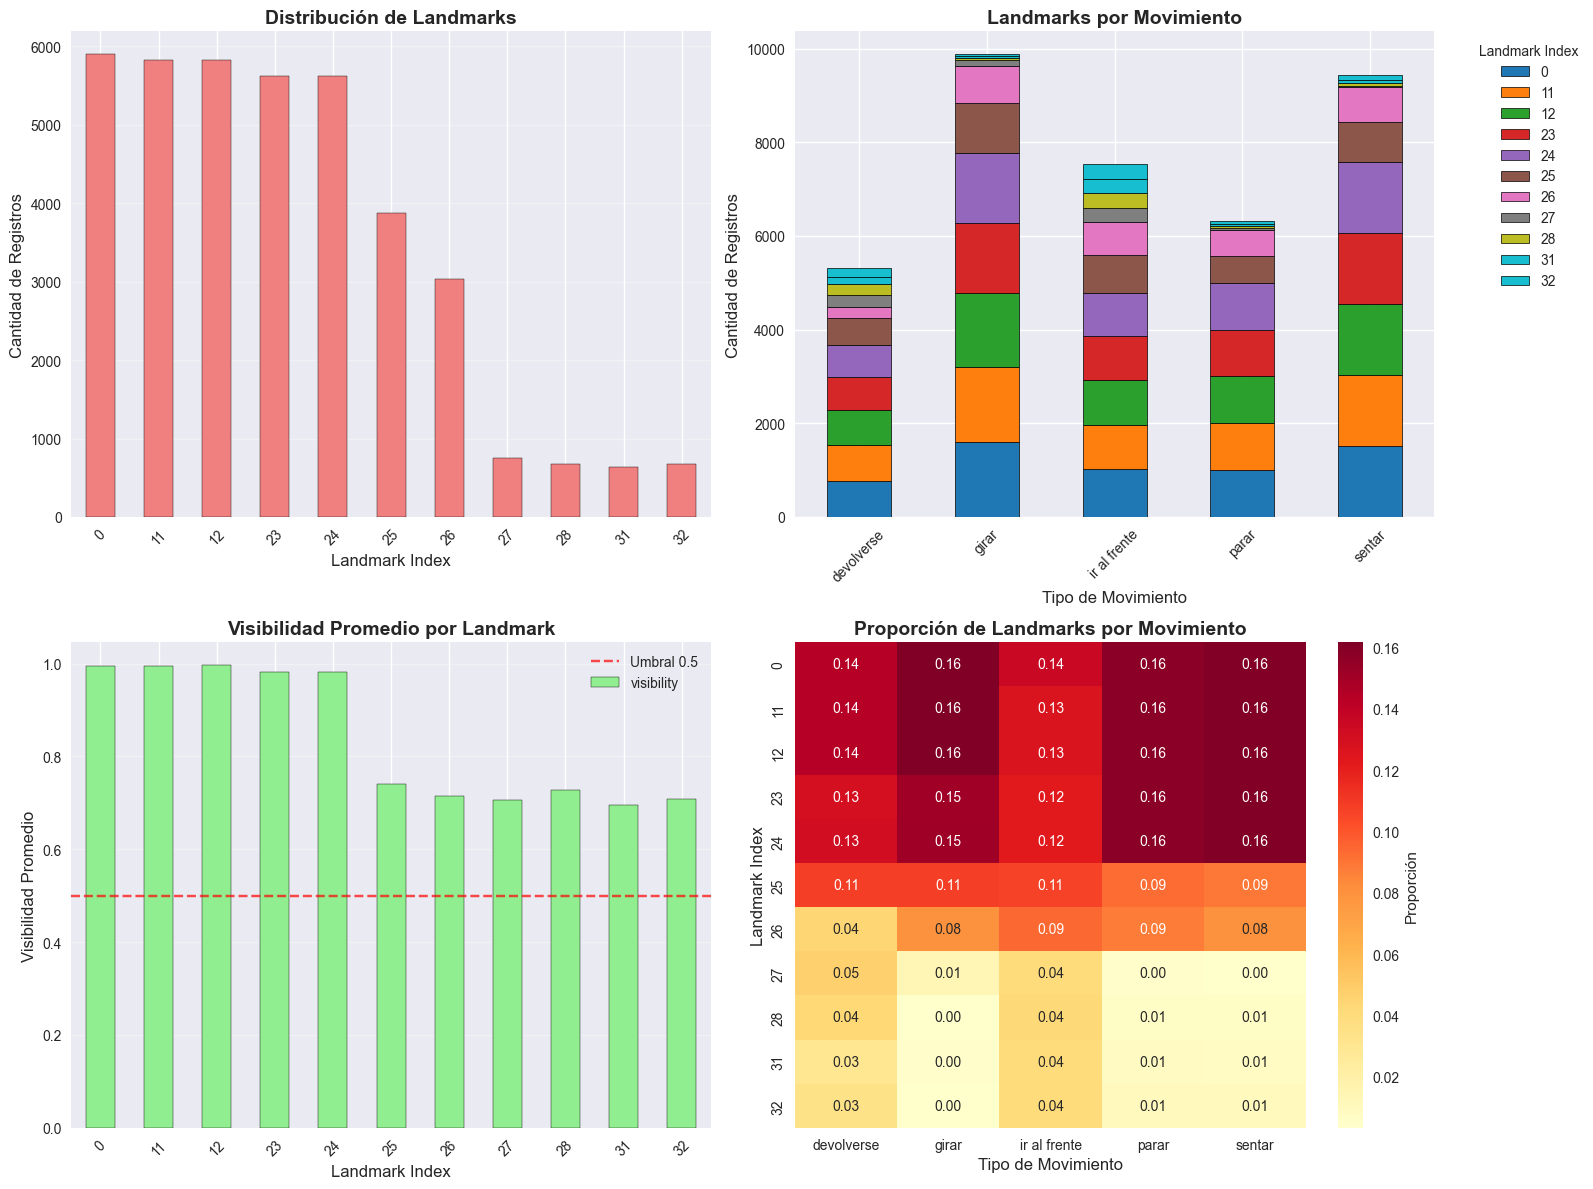

In [81]:
# Visualización de distribución de landmarks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución general de landmarks
landmark_counts.plot(kind='bar', ax=axes[0,0], color='lightcoral', edgecolor='black')
axes[0,0].set_title('Distribución de Landmarks', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Landmark Index', fontsize=12)
axes[0,0].set_ylabel('Cantidad de Registros', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Distribución de landmarks por movimiento
landmark_movement = df.groupby(['movement', 'landmark_index']).size().unstack(fill_value=0)
landmark_movement.plot(kind='bar', ax=axes[0,1], stacked=True, 
                      colormap='tab10', edgecolor='black', linewidth=0.5)
axes[0,1].set_title('Landmarks por Movimiento', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0,1].set_ylabel('Cantidad de Registros', fontsize=12)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Landmark Index', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Distribución de visibility por landmark
visibility_by_landmark = df.groupby('landmark_index')['visibility'].mean()
visibility_by_landmark.plot(kind='bar', ax=axes[1,0], color='lightgreen', edgecolor='black')
axes[1,0].set_title('Visibilidad Promedio por Landmark', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Landmark Index', fontsize=12)
axes[1,0].set_ylabel('Visibilidad Promedio', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
axes[1,0].legend()

# 4. Heatmap de landmarks por movimiento (normalizado)
landmark_movement_norm = landmark_movement.div(landmark_movement.sum(axis=1), axis=0)
sns.heatmap(landmark_movement_norm.T, ax=axes[1,1], annot=True, fmt='.2f', 
            cmap='YlOrRd', cbar_kws={'label': 'Proporción'})
axes[1,1].set_title('Proporción de Landmarks por Movimiento', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[1,1].set_ylabel('Landmark Index', fontsize=12)

plt.tight_layout()
plt.show()


In [82]:
# Análisis estadístico de coordenadas por movimiento
print("ANÁLISIS ESTADÍSTICO DE COORDENADAS POR MOVIMIENTO")
print("="*60)

coordinates = ['x', 'y', 'z', 'visibility']
stats_by_movement = df.groupby('movement')[coordinates].agg(['mean', 'std', 'min', 'max'])

for coord in coordinates:
    print(f"\n{coord.upper()} - Estadísticas por movimiento:")
    print("-" * 40)
    coord_stats = stats_by_movement[coord].round(4)
    display(coord_stats)

# Análisis de rangos por movimiento
print("\nRANGOS DE COORDENADAS POR MOVIMIENTO")
print("="*40)

for movement in df['movement'].unique():
    print(f"\n{movement.upper()}:")
    movement_data = df[df['movement'] == movement]
    for coord in ['x', 'y', 'z']:
        min_val = movement_data[coord].min()
        max_val = movement_data[coord].max()
        range_val = max_val - min_val
        print(f"  {coord}: [{min_val:.4f}, {max_val:.4f}] (rango: {range_val:.4f})")
    
    avg_visibility = movement_data['visibility'].mean()
    print(f"  Visibilidad promedio: {avg_visibility:.4f}")


ANÁLISIS ESTADÍSTICO DE COORDENADAS POR MOVIMIENTO

X - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.5041,0.0885,0.2678,1.0438
girar,0.4963,0.0569,0.2332,0.7952
ir al frente,0.5162,0.0714,0.2004,0.8249
parar,0.5037,0.0756,0.2950,0.7895
sentar,0.4977,0.0714,0.2909,0.7350



Y - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.5548,0.3197,-1.0758,1.9233
girar,0.5114,0.3001,-0.7173,1.5319
ir al frente,0.5692,0.3062,-0.5718,1.2428
parar,0.6823,0.2124,0.1802,1.2272
sentar,0.6761,0.2113,0.1811,1.2858



Z - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,-0.0129,0.2466,-1.1026,1.5684
girar,-0.0255,0.1531,-1.1504,0.8437
ir al frente,-0.0500,0.2129,-1.2767,1.4303
parar,-0.0786,0.1550,-0.8597,0.2349
sentar,-0.0749,0.1468,-0.7599,0.3372



VISIBILITY - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.9180,0.1382,0.5001,1.0000
girar,0.9252,0.1377,0.5001,1.0000
ir al frente,0.9092,0.1358,0.5001,1.0000
parar,0.9250,0.1387,0.5001,1.0000
sentar,0.9330,0.1353,0.5002,1.0000



RANGOS DE COORDENADAS POR MOVIMIENTO

GIRAR:
  x: [0.2332, 0.7952] (rango: 0.5621)
  y: [-0.7173, 1.5319] (rango: 2.2492)
  z: [-1.1504, 0.8437] (rango: 1.9940)
  Visibilidad promedio: 0.9252

SENTAR:
  x: [0.2909, 0.7350] (rango: 0.4441)
  y: [0.1811, 1.2858] (rango: 1.1047)
  z: [-0.7599, 0.3372] (rango: 1.0971)
  Visibilidad promedio: 0.9330

PARAR:
  x: [0.2950, 0.7895] (rango: 0.4945)
  y: [0.1802, 1.2272] (rango: 1.0470)
  z: [-0.8597, 0.2349] (rango: 1.0946)
  Visibilidad promedio: 0.9250

IR AL FRENTE:
  x: [0.2004, 0.8249] (rango: 0.6245)
  y: [-0.5718, 1.2428] (rango: 1.8146)
  z: [-1.2767, 1.4303] (rango: 2.7070)
  Visibilidad promedio: 0.9092

DEVOLVERSE:
  x: [0.2678, 1.0438] (rango: 0.7761)
  y: [-1.0758, 1.9233] (rango: 2.9990)
  z: [-1.1026, 1.5684] (rango: 2.6709)
  Visibilidad promedio: 0.9180


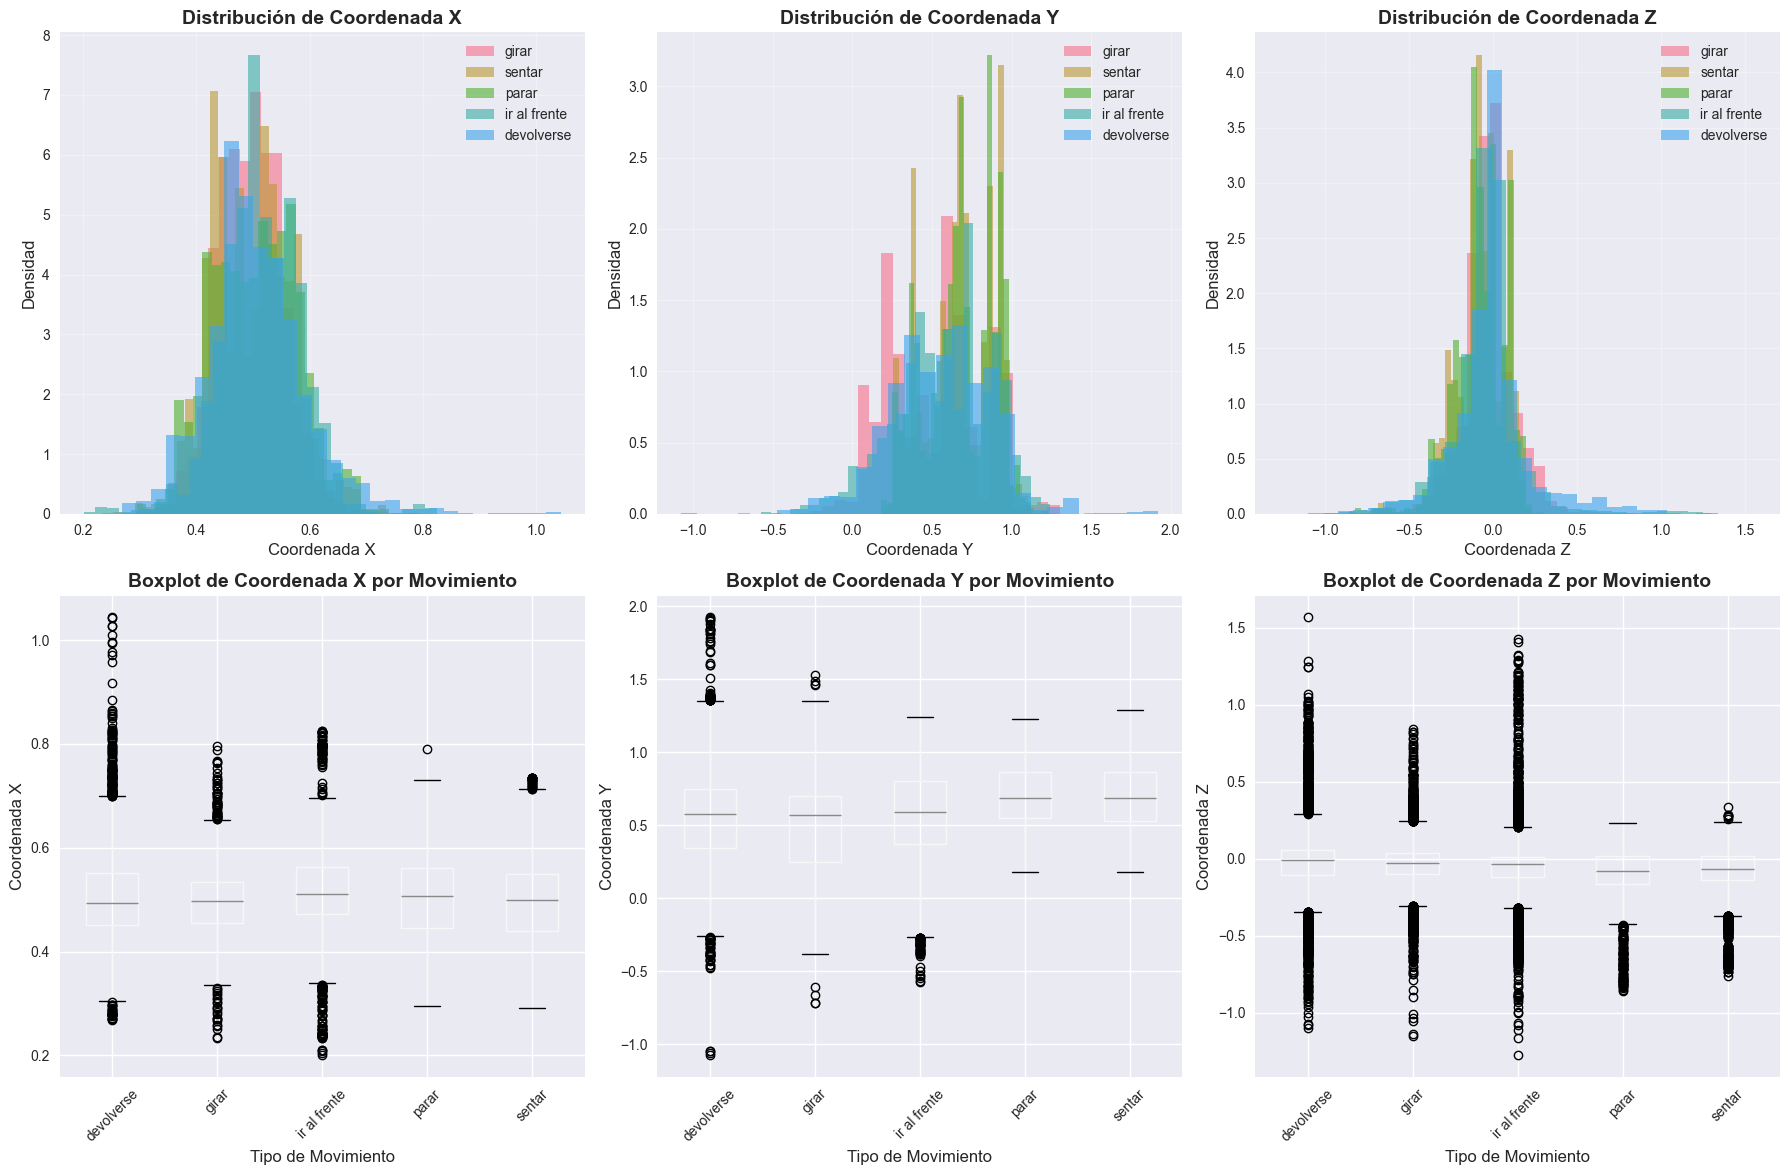

In [83]:
# Visualización de distribuciones de coordenadas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribuciones de X, Y, Z por movimiento
coordinates = ['x', 'y', 'z']
for i, coord in enumerate(coordinates):
    # Histogramas por movimiento
    for movement in df['movement'].unique():
        movement_data = df[df['movement'] == movement][coord]
        axes[0, i].hist(movement_data, alpha=0.6, label=movement, bins=30, density=True)
    
    axes[0, i].set_title(f'Distribución de Coordenada {coord.upper()}', fontsize=14, fontweight='bold')
    axes[0, i].set_xlabel(f'Coordenada {coord.upper()}', fontsize=12)
    axes[0, i].set_ylabel('Densidad', fontsize=12)
    axes[0, i].legend()
    axes[0, i].grid(alpha=0.3)

# Boxplots por movimiento
for i, coord in enumerate(coordinates):
    df.boxplot(column=coord, by='movement', ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot de Coordenada {coord.upper()} por Movimiento', fontsize=14, fontweight='bold')
    axes[1, i].set_xlabel('Tipo de Movimiento', fontsize=12)
    axes[1, i].set_ylabel(f'Coordenada {coord.upper()}', fontsize=12)
    axes[1, i].tick_params(axis='x', rotation=45)

plt.suptitle('')  # Remover título automático del boxplot
plt.tight_layout()
plt.show()


In [84]:
# Análisis temporal de frames
print("ANÁLISIS TEMPORAL DE FRAMES")
print("="*40)

# Estadísticas de frames por movimiento
frame_stats = df.groupby('movement')['frame'].agg(['count', 'min', 'max', 'nunique']).round(2)
frame_stats.columns = ['Total_Landmarks', 'Frame_Min', 'Frame_Max', 'Frames_Unicos']

print("Estadísticas de frames por movimiento:")
display(frame_stats)

# Duración promedio de secuencias (asumiendo que cada frame representa un punto temporal)
print("\nDuración de secuencias por movimiento:")
for movement in df['movement'].unique():
    movement_data = df[df['movement'] == movement]
    unique_frames = movement_data['frame'].nunique()
    landmarks_per_frame = len(movement_data) / unique_frames
    print(f"  {movement}:")
    print(f"    Frames únicos: {unique_frames}")
    print(f"    Landmarks por frame: {landmarks_per_frame:.1f}")
    print(f"    Duración relativa: {unique_frames} frames")


ANÁLISIS TEMPORAL DE FRAMES
Estadísticas de frames por movimiento:


,Total_Landmarks,Frame_Min,Frame_Max,Frames_Unicos
movement,,,,
devolverse,5305,0,152,153
girar,9873,0,135,136
ir al frente,7528,0,132,133
parar,6321,0,114,115
sentar,9429,0,169,170



Duración de secuencias por movimiento:
  girar:
    Frames únicos: 136
    Landmarks por frame: 72.6
    Duración relativa: 136 frames
  sentar:
    Frames únicos: 170
    Landmarks por frame: 55.5
    Duración relativa: 170 frames
  parar:
    Frames únicos: 115
    Landmarks por frame: 55.0
    Duración relativa: 115 frames
  ir al frente:
    Frames únicos: 133
    Landmarks por frame: 56.6
    Duración relativa: 133 frames
  devolverse:
    Frames únicos: 153
    Landmarks por frame: 34.7
    Duración relativa: 153 frames


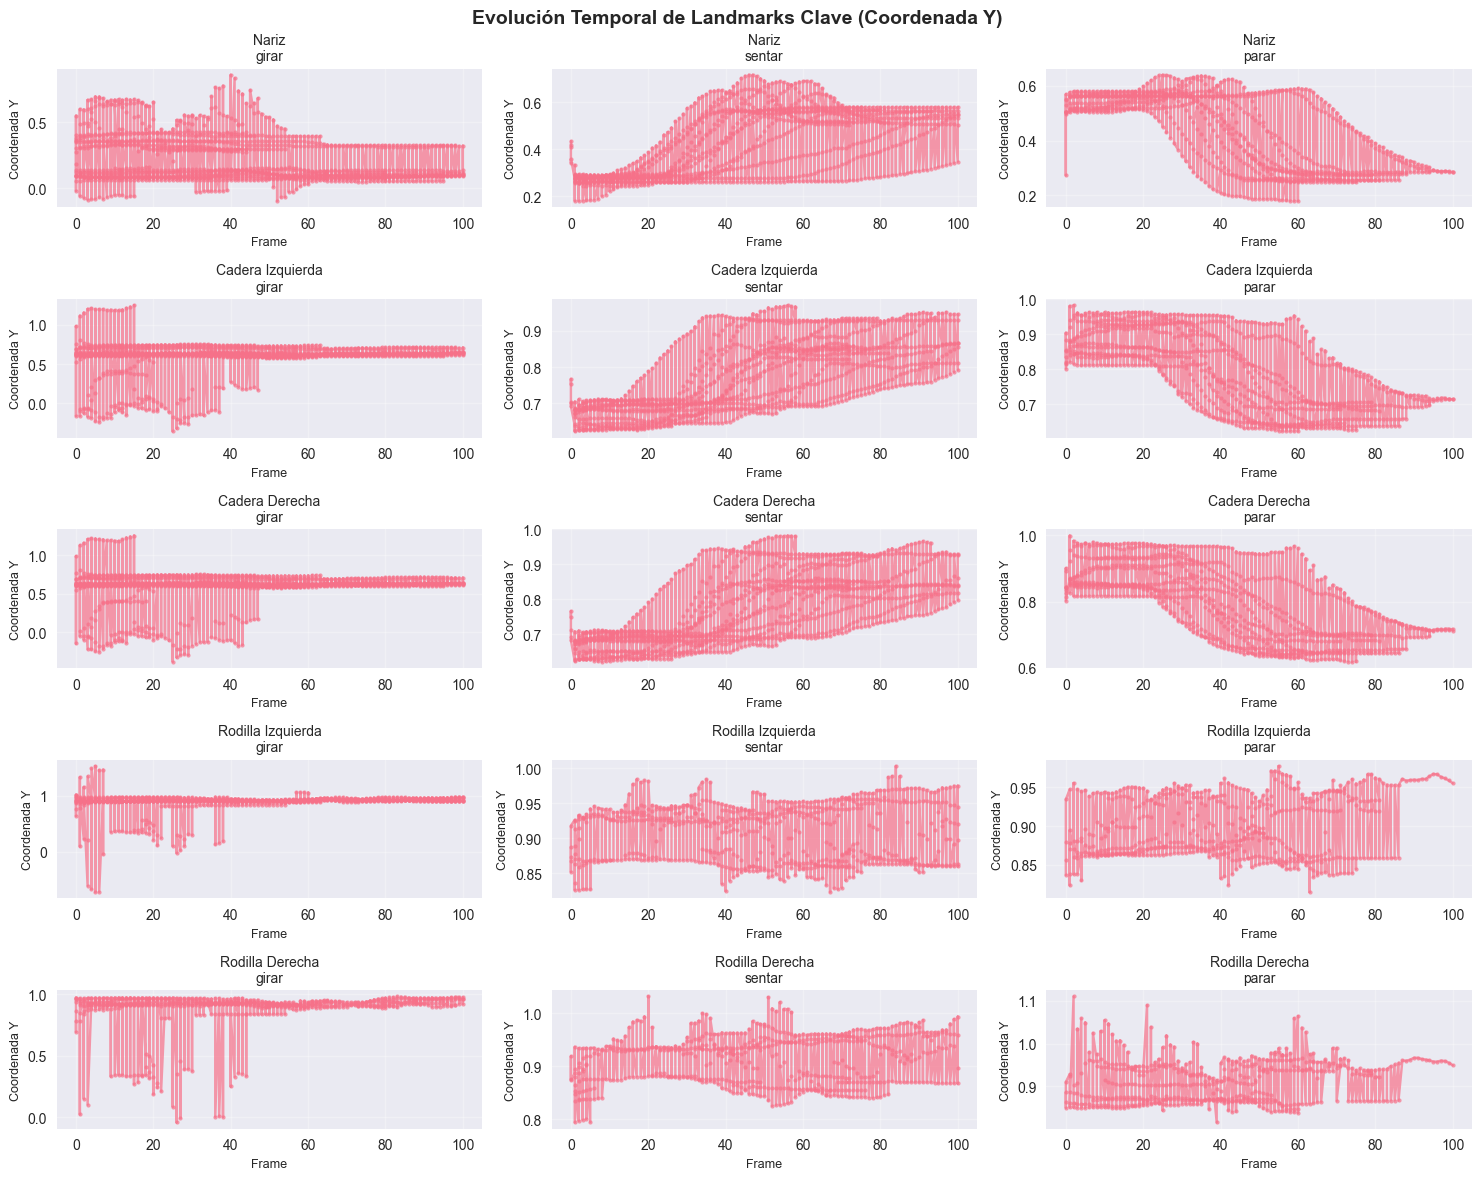

In [85]:
# Análisis de evolución temporal de landmarks clave
# Seleccionar algunos landmarks importantes y movimientos para visualizar patrones temporales

# Definir landmarks clave para análisis temporal
key_landmarks = {
    0: "Nariz",
    23: "Cadera Izquierda", 
    24: "Cadera Derecha",
    25: "Rodilla Izquierda", 
    26: "Rodilla Derecha"
}

# Tomar una muestra de datos para visualización temporal
sample_movements = ['girar', 'sentar', 'parar']
sample_size = 100  # Primeros 100 frames por movimiento

fig, axes = plt.subplots(len(key_landmarks), len(sample_movements), figsize=(15, 12))

for i, (landmark_idx, landmark_name) in enumerate(key_landmarks.items()):
    for j, movement in enumerate(sample_movements):
        # Filtrar datos para este landmark y movimiento
        subset = df[(df['landmark_index'] == landmark_idx) & 
                   (df['movement'] == movement) & 
                   (df['frame'] <= sample_size)].copy()
        
        if len(subset) > 0:
            # Ordenar por frame
            subset = subset.sort_values('frame')
            
            # Graficar evolución de coordenada Y (altura)
            axes[i, j].plot(subset['frame'], subset['y'], 'o-', alpha=0.7, markersize=3)
            axes[i, j].set_title(f'{landmark_name}\n{movement}', fontsize=10)
            axes[i, j].set_xlabel('Frame', fontsize=9)
            axes[i, j].set_ylabel('Coordenada Y', fontsize=9)
            axes[i, j].grid(alpha=0.3)
        else:
            axes[i, j].text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].set_title(f'{landmark_name}\n{movement}', fontsize=10)

plt.suptitle('Evolución Temporal de Landmarks Clave (Coordenada Y)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


ANÁLISIS DE CORRELACIONES
Matriz de correlación entre variables numéricas:


,x,y,z,visibility
x,1.0000,0.0042,0.0172,-0.0371
y,0.0042,1.0000,-0.1014,-0.5108
z,0.0172,-0.1014,1.0000,0.0527
visibility,-0.0371,-0.5108,0.0527,1.0000


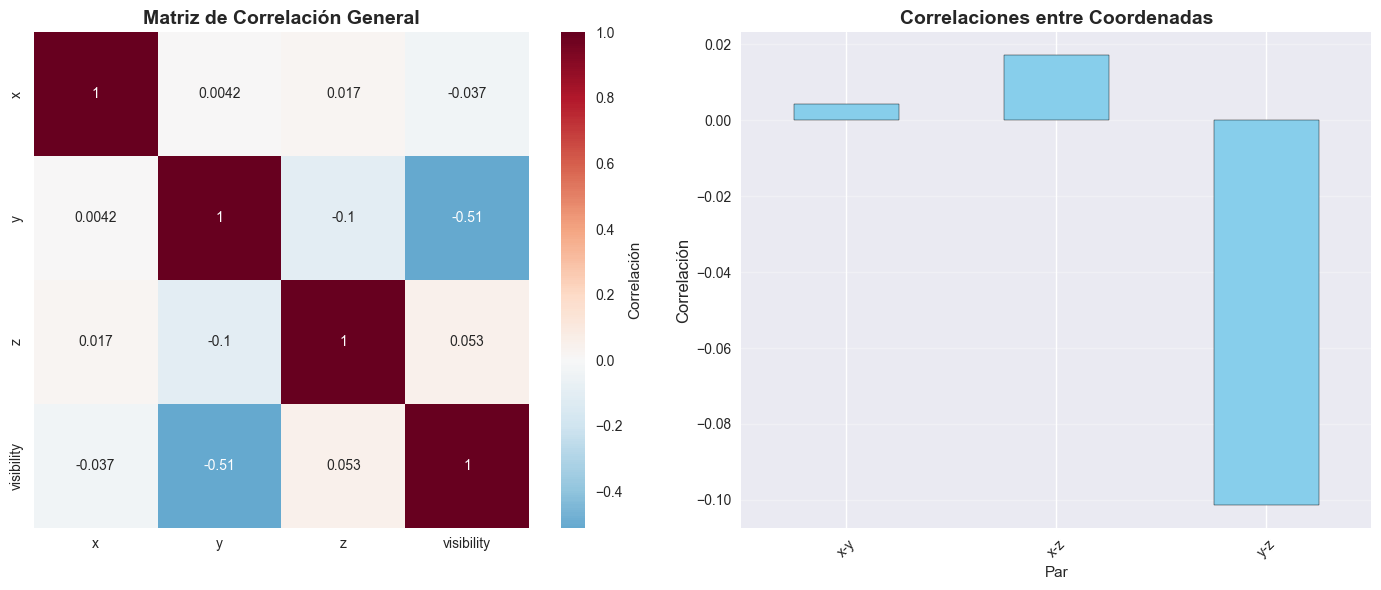

In [86]:
# Matriz de correlación entre coordenadas
print("ANÁLISIS DE CORRELACIONES")
print("="*30)

# Matriz de correlación general
corr_matrix = df[['x', 'y', 'z', 'visibility']].corr()

print("Matriz de correlación entre variables numéricas:")
display(corr_matrix.round(4))

# Visualización de matriz de correlación
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap general
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlación'})
axes[0].set_title('Matriz de Correlación General', fontsize=14, fontweight='bold')

# Correlación por pares específicos
coords = ['x', 'y', 'z']
pair_correlations = []

for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        coord1, coord2 = coords[i], coords[j]
        correlation = df[coord1].corr(df[coord2])
        pair_correlations.append({
            'Par': f'{coord1}-{coord2}',
            'Correlación': correlation
        })

pair_df = pd.DataFrame(pair_correlations)
pair_df.set_index('Par')['Correlación'].plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Correlaciones entre Coordenadas', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Correlación', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


CORRELACIONES ENTRE LANDMARKS ESPECÍFICOS


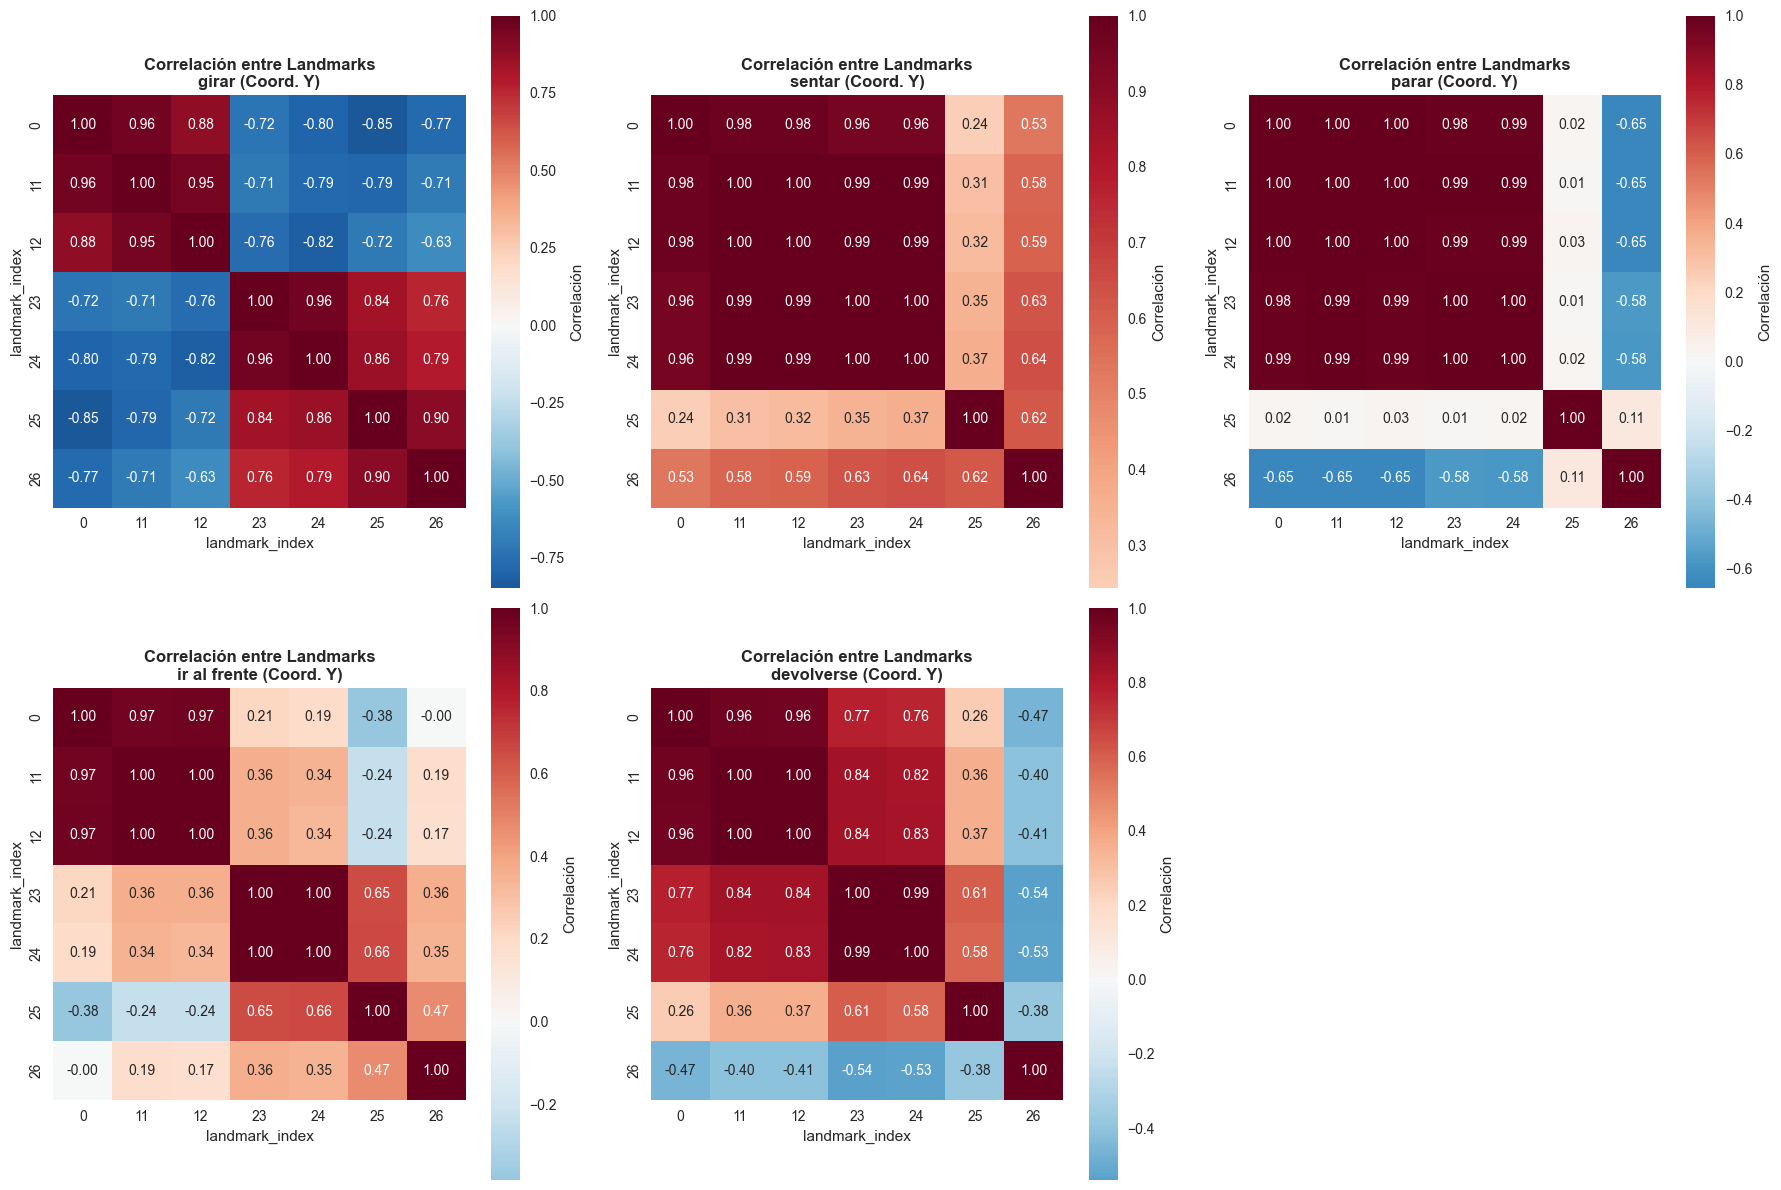

In [87]:
# Análisis de correlaciones entre landmarks específicos
# Analizar correlaciones entre landmarks clave para cada movimiento

print("CORRELACIONES ENTRE LANDMARKS ESPECÍFICOS")
print("="*45)

# Seleccionar landmarks clave para análisis de correlación
key_landmarks_list = [0, 11, 12, 23, 24, 25, 26]

# Crear dataset pivotado para análisis de correlaciones entre landmarks
def create_landmark_correlation_matrix(movement_data, coordinate='y'):
    """Crea una matriz de correlación entre landmarks para una coordenada específica"""
    pivot_data = movement_data.pivot_table(
        index='frame', 
        columns='landmark_index', 
        values=coordinate, 
        fill_value=0
    )
    
    # Filtrar solo landmarks clave que existen en los datos
    available_landmarks = [lm for lm in key_landmarks_list if lm in pivot_data.columns]
    if available_landmarks:
        return pivot_data[available_landmarks].corr()
    else:
        return None

# Analizar correlaciones por movimiento para coordenada Y (más relevante para movimientos)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

movements = df['movement'].unique()
for i, movement in enumerate(movements):
    if i < len(axes):
        movement_data = df[df['movement'] == movement]
        corr_matrix = create_landmark_correlation_matrix(movement_data, 'y')
        
        if corr_matrix is not None and not corr_matrix.empty:
            sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                       square=True, ax=axes[i], cbar_kws={'label': 'Correlación'},
                       fmt='.2f')
            axes[i].set_title(f'Correlación entre Landmarks\n{movement} (Coord. Y)', 
                            fontsize=12, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center', 
                        transform=axes[i].transAxes)
            axes[i].set_title(f'{movement}\n(Sin datos suficientes)', fontsize=12)

# Ocultar ejes no utilizados
for i in range(len(movements), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


ANÁLISIS DE SEPARABILIDAD DE CLASES
Varianza explicada por cada componente:
  PC1: 0.3611 (36.11%)
  PC2: 0.1792 (17.92%)
  PC3: 0.1700 (17.00%)
Varianza acumulada: 0.7104 (71.04%)


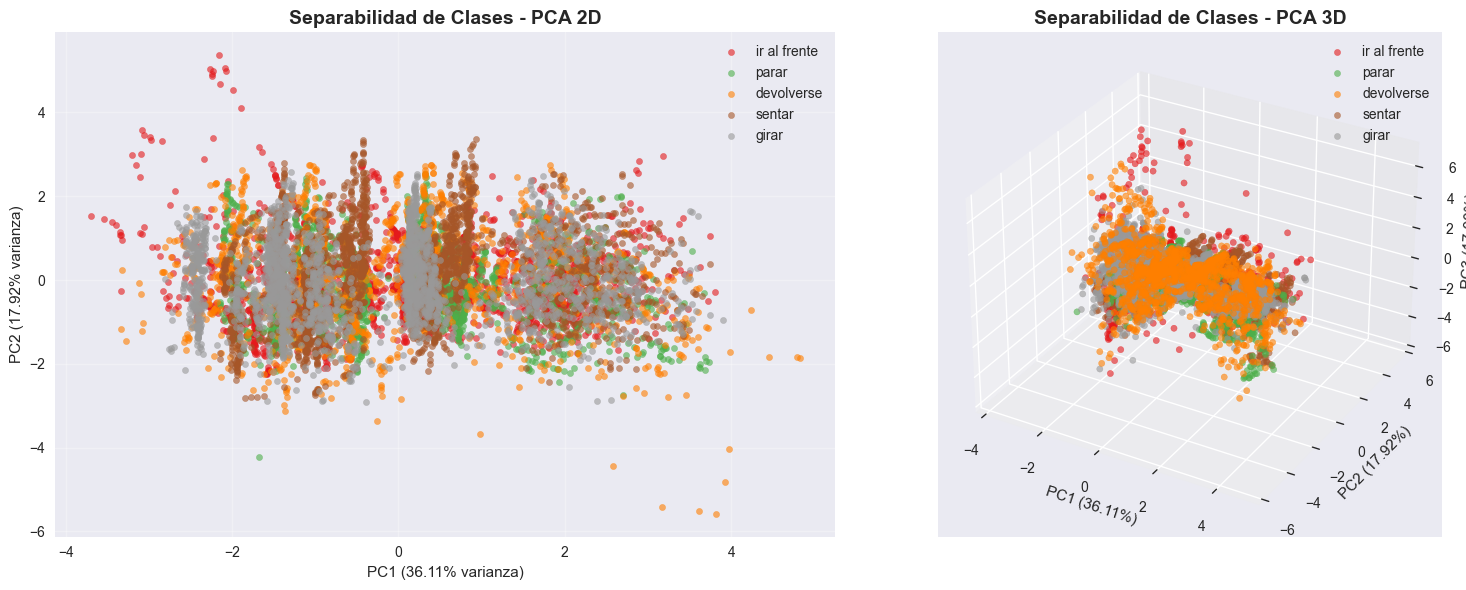

In [88]:
# Análisis de separabilidad entre clases usando PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("ANÁLISIS DE SEPARABILIDAD DE CLASES")
print("="*40)

# Preparar datos para PCA - usar una muestra para eficiencia
sample_size = 10000  # Tomar muestra aleatoria
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df.copy()

# Crear features para PCA
features_for_pca = ['x', 'y', 'z', 'visibility', 'landmark_index', 'frame']
X = df_sample[features_for_pca]
y = df_sample['movement']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por cada componente:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

print(f"Varianza acumulada: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Crear DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['movement'] = y.reset_index(drop=True)

# Visualización 2D y 3D
fig = plt.figure(figsize=(16, 6))

# Plot 2D
ax1 = fig.add_subplot(121)
colors = plt.cm.Set1(np.linspace(0, 1, len(pca_df['movement'].unique())))
for i, movement in enumerate(pca_df['movement'].unique()):
    mask = pca_df['movement'] == movement
    ax1.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
               c=[colors[i]], label=movement, alpha=0.6, s=20)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
ax1.set_title('Separabilidad de Clases - PCA 2D', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 3D
ax2 = fig.add_subplot(122, projection='3d')
for i, movement in enumerate(pca_df['movement'].unique()):
    mask = pca_df['movement'] == movement
    ax2.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], pca_df[mask]['PC3'],
               c=[colors[i]], label=movement, alpha=0.6, s=20)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax2.set_title('Separabilidad de Clases - PCA 3D', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()


In [89]:
# Análisis de calidad de detección de landmarks
print("ANÁLISIS DE CALIDAD DE DETECCIÓN")
print("="*40)

# Análisis de visibility por landmark y movimiento
visibility_analysis = df.groupby(['movement', 'landmark_index'])['visibility'].agg([
    'mean', 'std', 'min', 'max', 'count'
]).round(4)

print("Estadísticas de visibilidad por movimiento y landmark:")
print("(Values closer to 1.0 indicate better detection quality)")
display(visibility_analysis.head(20))

# Identificar landmarks con baja visibilidad
low_visibility_threshold = 0.5
low_visibility_landmarks = df.groupby('landmark_index')['visibility'].mean()
problematic_landmarks = low_visibility_landmarks[low_visibility_landmarks < low_visibility_threshold]

print(f"\nLandmarks con visibilidad promedio < {low_visibility_threshold}:")
if len(problematic_landmarks) > 0:
    for landmark_idx, avg_visibility in problematic_landmarks.items():
        landmark_name = landmark_names.get(landmark_idx, f"Landmark {landmark_idx}")
        print(f"  {landmark_idx} - {landmark_name}: {avg_visibility:.4f}")
else:
    print("  ✅ Todos los landmarks tienen buena visibilidad")

# Análisis de outliers en coordenadas
print(f"\nANÁLISIS DE OUTLIERS")
print("="*25)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for coord in ['x', 'y', 'z']:
    outliers, lower, upper = detect_outliers_iqr(df, coord)
    outlier_percentage = (len(outliers) / len(df)) * 100
    print(f"\nCoordenada {coord.upper()}:")
    print(f"  Rango normal: [{lower:.4f}, {upper:.4f}]")
    print(f"  Outliers detectados: {len(outliers):,} ({outlier_percentage:.2f}%)")
    
    if outlier_percentage > 5:
        print(f"  ⚠️ Alto porcentaje de outliers - revisar calidad de datos")
    elif outlier_percentage > 1:
        print(f"  ⚠️ Moderado porcentaje de outliers")
    else:
        print(f"  ✅ Bajo porcentaje de outliers")


ANÁLISIS DE CALIDAD DE DETECCIÓN
Estadísticas de visibilidad por movimiento y landmark:
(Values closer to 1.0 indicate better detection quality)


mean    std    min    max  count
movement   landmark_index                                   
devolverse 0              0.9923 0.0126 0.8743 0.9999    763
           11             0.9960 0.0079 0.9531 1.0000    763
           12             0.9969 0.0056 0.9677 1.0000    763
           23             0.9702 0.0887 0.5017 0.9999    690
           24             0.9677 0.0924 0.5047 0.9998    695
           25             0.7744 0.1297 0.5013 0.9853    575
           26             0.8209 0.1624 0.5003 0.9863    236
           27             0.7531 0.1613 0.5027 0.9827    250
           28             0.7645 0.1517 0.5004 0.9808    228
           31             0.7300 0.1508 0.5003 0.9232    160
           32             0.7240 0.1211 0.5001 0.9243    182
girar      0              0.9927 0.0260 0.6680 1.0000   1596
           11             0.9960 0.0109 0.9026 1.0000   1596
           12             0.9968 0.0088 0.9281 1.0000   1596
           23             0.9697 0.0826 0.5003 0.9997   1489
           24             0.9698 0.0820 0.5006 0.9996   1494
           25             0.7597 0.1020 0.5003 0.9739   1065
           26             0.6596 0.1194 0.5006 0.9811    788
           27             0.5774 0.0843 0.5005 0.9629    138
           28             0.6360 0.1144 0.5054 0.9585     34


Landmarks con visibilidad promedio < 0.5:
  ✅ Todos los landmarks tienen buena visibilidad

ANÁLISIS DE OUTLIERS

Coordenada X:
  Rango normal: [0.3037, 0.6967]
  Outliers detectados: 444 (1.15%)
  ⚠️ Moderado porcentaje de outliers

Coordenada Y:
  Rango normal: [-0.2825, 1.5134]
  Outliers detectados: 111 (0.29%)
  ✅ Bajo porcentaje de outliers

Coordenada Z:
  Rango normal: [-0.3482, 0.2549]
  Outliers detectados: 3,006 (7.82%)
  ⚠️ Alto porcentaje de outliers - revisar calidad de datos


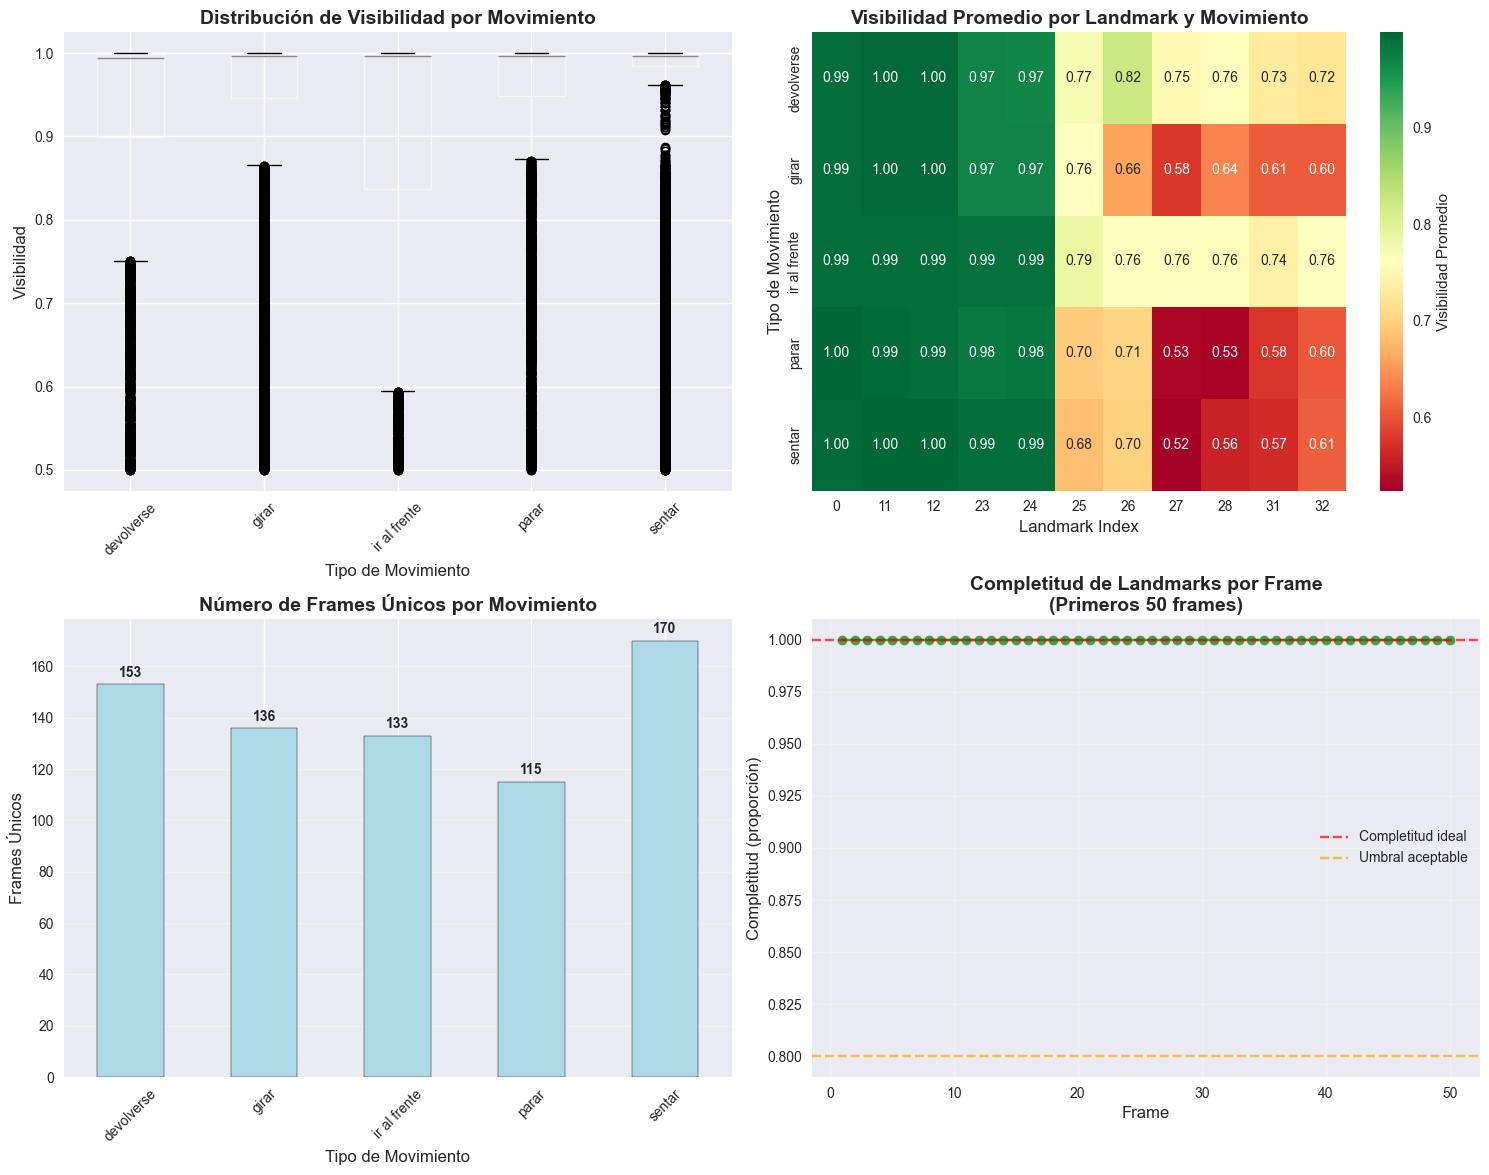

In [90]:
# Visualización de calidad de datos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de visibility por movimiento
df.boxplot(column='visibility', by='movement', ax=axes[0,0])
axes[0,0].set_title('Distribución de Visibilidad por Movimiento', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0,0].set_ylabel('Visibilidad', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Heatmap de visibilidad por landmark y movimiento
visibility_heatmap = df.groupby(['movement', 'landmark_index'])['visibility'].mean().unstack()
sns.heatmap(visibility_heatmap, annot=True, cmap='RdYlGn', ax=axes[0,1], 
            cbar_kws={'label': 'Visibilidad Promedio'}, fmt='.2f')
axes[0,1].set_title('Visibilidad Promedio por Landmark y Movimiento', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Landmark Index', fontsize=12)
axes[0,1].set_ylabel('Tipo de Movimiento', fontsize=12)

# 3. Distribución de frames por movimiento
frame_counts_by_movement = df.groupby('movement')['frame'].nunique()
frame_counts_by_movement.plot(kind='bar', ax=axes[1,0], color='lightblue', edgecolor='black')
axes[1,0].set_title('Número de Frames Únicos por Movimiento', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[1,0].set_ylabel('Frames Únicos', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(frame_counts_by_movement.values):
    axes[1,0].text(i, v + max(frame_counts_by_movement)*0.01, f'{v}', 
                  ha='center', va='bottom', fontweight='bold')

# 4. Completitud de landmarks por frame (muestra)
sample_frames = df['frame'].unique()[:50]  # Primeros 50 frames
completeness_data = []

for frame in sample_frames:
    frame_data = df[df['frame'] == frame]
    unique_landmarks = frame_data['landmark_index'].nunique()
    total_expected = len(landmark_names)
    completeness = unique_landmarks / total_expected
    completeness_data.append(completeness)

axes[1,1].plot(sample_frames, completeness_data, 'o-', color='green', alpha=0.7)
axes[1,1].set_title('Completitud de Landmarks por Frame\n(Primeros 50 frames)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Frame', fontsize=12)
axes[1,1].set_ylabel('Completitud (proporción)', fontsize=12)
axes[1,1].grid(alpha=0.3)
axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Completitud ideal')
axes[1,1].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Umbral aceptable')
axes[1,1].legend()

plt.suptitle('')  # Remover título automático
plt.tight_layout()
plt.show()


In [91]:
# Resumen ejecutivo del análisis
print("="*60)
print("RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS")
print("="*60)

print(f"\n📊 DIMENSIONES DEL DATASET:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Landmarks únicos: {df['landmark_index'].nunique()}")
print(f"   • Frames únicos: {df['frame'].nunique():,}")
print(f"   • Clases de movimiento: {df['movement'].nunique()}")

print(f"\n🎯 DISTRIBUCIÓN DE CLASES:")
for movement, count in movement_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   • {movement}: {count:,} ({percentage:.1f}%)")

print(f"\n📈 CALIDAD DE DATOS:")
null_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
duplicates_percentage = (df.duplicated().sum() / len(df)) * 100
avg_visibility = df['visibility'].mean()

print(f"   • Valores nulos: {null_percentage:.2f}%")
print(f"   • Registros duplicados: {duplicates_percentage:.2f}%")
print(f"   • Visibilidad promedio: {avg_visibility:.3f}")

print(f"\n🔍 CARACTERÍSTICAS DE LOS DATOS:")
for coord in ['x', 'y', 'z']:
    coord_range = df[coord].max() - df[coord].min()
    coord_std = df[coord].std()
    print(f"   • Coordenada {coord.upper()}: rango={coord_range:.4f}, std={coord_std:.4f}")

# Balance del dataset
balance_ratio = movement_counts.min() / movement_counts.max()
print(f"\n⚖️ BALANCE DEL DATASET:")
print(f"   • Ratio de balance: {balance_ratio:.3f}")
if balance_ratio >= 0.8:
    print("   • Estado: ✅ Bien balanceado")
elif balance_ratio >= 0.5:
    print("   • Estado: ⚠️ Moderadamente balanceado")
else:
    print("   • Estado: ❌ Desbalanceado")

print(f"\n🎯 SEPARABILIDAD DE CLASES:")
print(f"   • Análisis PCA realizado con {len(df_sample):,} muestras")
print(f"   • Varianza explicada (3 componentes): {pca.explained_variance_ratio_.sum():.2%}")
print(f"   • Las clases muestran cierta separabilidad en el espacio PCA")


RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS

📊 DIMENSIONES DEL DATASET:
   • Total de registros: 38,456
   • Landmarks únicos: 11
   • Frames únicos: 170
   • Clases de movimiento: 5

🎯 DISTRIBUCIÓN DE CLASES:
   • girar: 9,873 (25.7%)
   • sentar: 9,429 (24.5%)
   • ir al frente: 7,528 (19.6%)
   • parar: 6,321 (16.4%)
   • devolverse: 5,305 (13.8%)

📈 CALIDAD DE DATOS:
   • Valores nulos: 0.00%
   • Registros duplicados: 0.00%
   • Visibilidad promedio: 0.923

🔍 CARACTERÍSTICAS DE LOS DATOS:
   • Coordenada X: rango=0.8434, std=0.0718
   • Coordenada Y: rango=2.9990, std=0.2810
   • Coordenada Z: rango=2.8451, std=0.1821

⚖️ BALANCE DEL DATASET:
   • Ratio de balance: 0.537
   • Estado: ⚠️ Moderadamente balanceado

🎯 SEPARABILIDAD DE CLASES:
   • Análisis PCA realizado con 10,000 muestras
   • Varianza explicada (3 componentes): 71.04%
   • Las clases muestran cierta separabilidad en el espacio PCA


In [92]:
# Crear directorio para datos procesados
import os
from pathlib import Path

# Crear directorio para exportar datos procesados
export_dir = Path('data')
export_dir.mkdir(exist_ok=True)

print("PREPROCESAMIENTO DE DATOS")
print("="*40)

# Trabajar con una copia del dataset original
df_processed = df.copy()

print(f"Dataset original: {df_processed.shape}")
print(f"Memoria original: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 1. LIMPIEZA DE DATOS
print(f"\n1. 🧹 LIMPIEZA DE DATOS")
print("-" * 25)

# Eliminar registros con baja visibilidad
visibility_threshold = 0.5
initial_count = len(df_processed)
df_processed = df_processed[df_processed['visibility'] >= visibility_threshold].copy()
removed_count = initial_count - len(df_processed)

print(f"   • Eliminados {removed_count:,} registros con visibilidad < {visibility_threshold}")
print(f"   • Registros restantes: {len(df_processed):,}")

# Verificar y eliminar duplicados si existen
duplicates_before = df_processed.duplicated().sum()
if duplicates_before > 0:
    df_processed = df_processed.drop_duplicates().reset_index(drop=True)
    print(f"   • Eliminados {duplicates_before:,} registros duplicados")

# 2. DETECCIÓN Y TRATAMIENTO DE OUTLIERS
print(f"\n2. 🎯 TRATAMIENTO DE OUTLIERS")
print("-" * 30)

def remove_outliers_iqr(data, columns, factor=1.5):
    """Elimina outliers usando el método IQR"""
    data_clean = data.copy()
    outliers_removed = 0
    
    for col in columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        initial_len = len(data_clean)
        data_clean = data_clean[(data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)]
        outliers_removed += initial_len - len(data_clean)
    
    return data_clean, outliers_removed

# Aplicar eliminación de outliers para coordenadas
coords_to_clean = ['x', 'y', 'z']
df_processed, outliers_removed = remove_outliers_iqr(df_processed, coords_to_clean, factor=2.0)

print(f"   • Outliers eliminados: {outliers_removed:,}")
print(f"   • Registros restantes: {len(df_processed):,}")

# 3. VALIDACIÓN DE INTEGRIDAD
print(f"\n3. ✅ VALIDACIÓN DE INTEGRIDAD")
print("-" * 32)

# Verificar que todos los movimientos siguen presentes
movements_before = set(df['movement'].unique())
movements_after = set(df_processed['movement'].unique())
missing_movements = movements_before - movements_after

if missing_movements:
    print(f"   ⚠️ Movimientos perdidos en la limpieza: {missing_movements}")
else:
    print(f"   ✅ Todos los movimientos preservados: {len(movements_after)}")

# Verificar landmarks
landmarks_before = set(df['landmark_index'].unique())
landmarks_after = set(df_processed['landmark_index'].unique())
missing_landmarks = landmarks_before - landmarks_after

if missing_landmarks:
    print(f"   ⚠️ Landmarks perdidos: {missing_landmarks}")
else:
    print(f"   ✅ Todos los landmarks preservados: {len(landmarks_after)}")

# 4. ESTADÍSTICAS FINALES
print(f"\n4. 📊 ESTADÍSTICAS FINALES")
print("-" * 26)

reduction_percentage = ((len(df) - len(df_processed)) / len(df)) * 100
print(f"   • Reducción del dataset: {reduction_percentage:.2f}%")
print(f"   • Registros finales: {len(df_processed):,}")
print(f"   • Memoria final: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


PREPROCESAMIENTO DE DATOS
Dataset original: (38456, 7)
Memoria original: 3.83 MB

1. 🧹 LIMPIEZA DE DATOS
-------------------------
   • Eliminados 0 registros con visibilidad < 0.5
   • Registros restantes: 38,456

2. 🎯 TRATAMIENTO DE OUTLIERS
------------------------------
   • Outliers eliminados: 1,828
   • Registros restantes: 36,628

3. ✅ VALIDACIÓN DE INTEGRIDAD
--------------------------------
   ✅ Todos los movimientos preservados: 5
   ✅ Todos los landmarks preservados: 11

4. 📊 ESTADÍSTICAS FINALES
--------------------------
   • Reducción del dataset: 4.75%
   • Registros finales: 36,628
   • Memoria final: 3.92 MB



COMPARACIÓN ANTES/DESPUÉS DEL PREPROCESAMIENTO


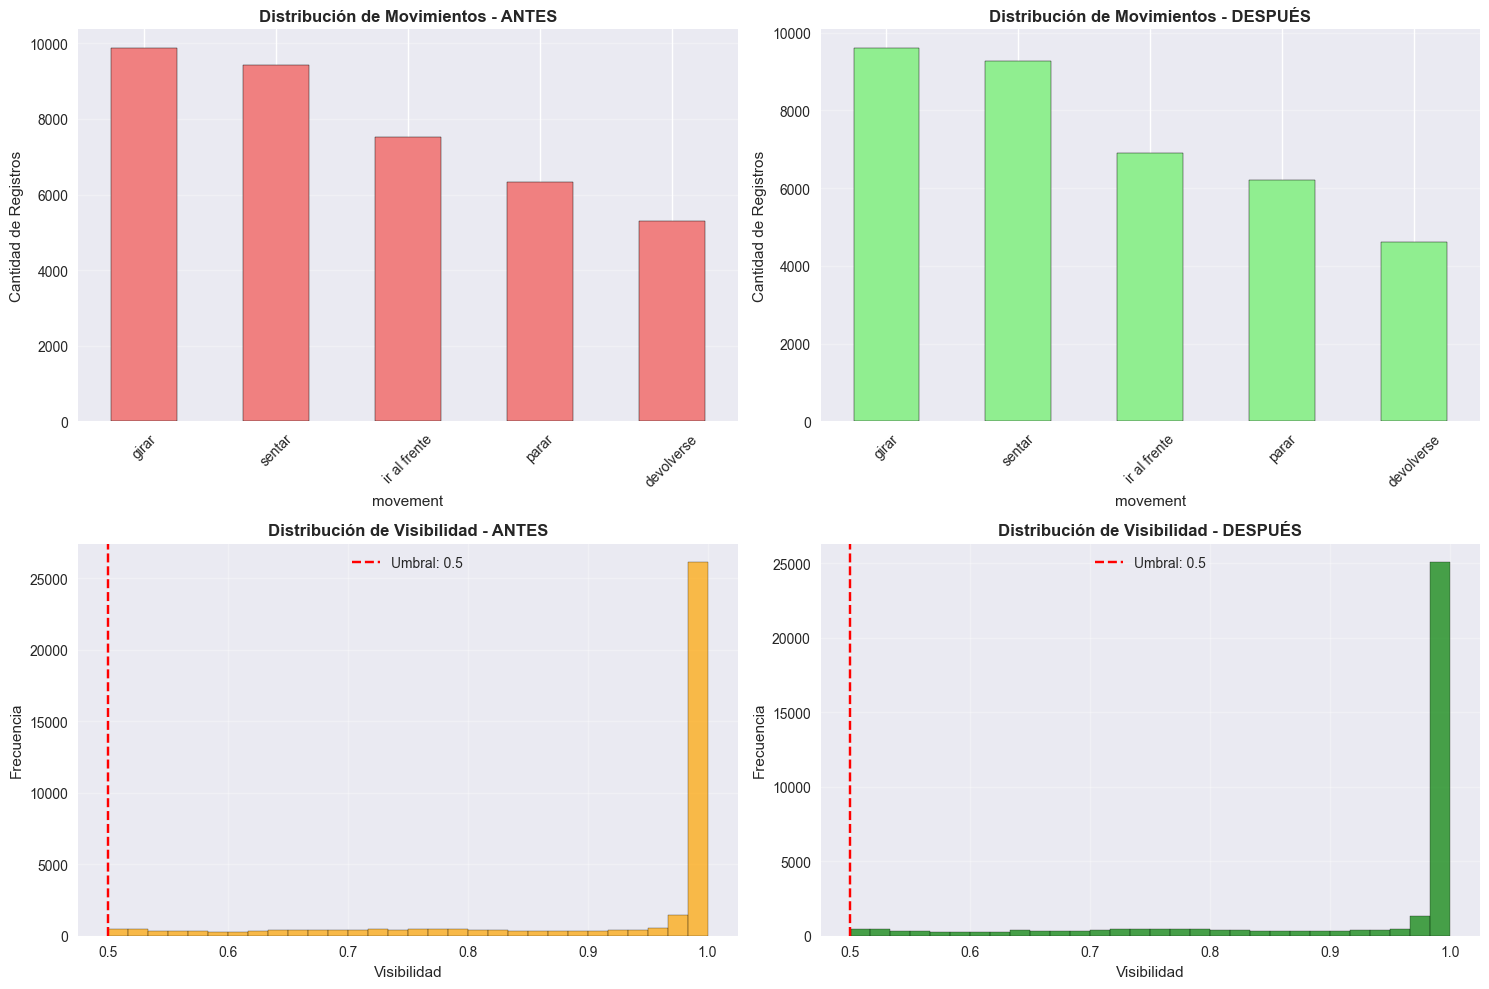


TABLA COMPARATIVA:
----------------------------------------


,Métrica,Antes,Después
0,Total Registros,"38,456","36,628"
1,Movimientos Únicos,5,5
2,Landmarks Únicos,11,11
3,Frames Únicos,170,170
4,Visibilidad Promedio,0.9229,0.9244
5,Valores Nulos,0,0
6,Duplicados,0,0


In [93]:
# Comparación antes y después del preprocesamiento
print("\n" + "="*50)
print("COMPARACIÓN ANTES/DESPUÉS DEL PREPROCESAMIENTO")
print("="*50)

# Crear visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribución de movimientos - ANTES
movement_counts_before = df['movement'].value_counts()
movement_counts_before.plot(kind='bar', ax=axes[0,0], color='lightcoral', edgecolor='black')
axes[0,0].set_title('Distribución de Movimientos - ANTES', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Cantidad de Registros')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Distribución de movimientos - DESPUÉS
movement_counts_after = df_processed['movement'].value_counts()
movement_counts_after.plot(kind='bar', ax=axes[0,1], color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribución de Movimientos - DESPUÉS', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Cantidad de Registros')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Distribución de visibilidad - ANTES
axes[1,0].hist(df['visibility'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].axvline(x=visibility_threshold, color='red', linestyle='--', label=f'Umbral: {visibility_threshold}')
axes[1,0].set_title('Distribución de Visibilidad - ANTES', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Visibilidad')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Distribución de visibilidad - DESPUÉS
axes[1,1].hist(df_processed['visibility'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,1].axvline(x=visibility_threshold, color='red', linestyle='--', label=f'Umbral: {visibility_threshold}')
axes[1,1].set_title('Distribución de Visibilidad - DESPUÉS', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Visibilidad')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa de estadísticas
print("\nTABLA COMPARATIVA:")
print("-" * 40)

comparison_data = {
    'Métrica': ['Total Registros', 'Movimientos Únicos', 'Landmarks Únicos', 'Frames Únicos', 
                'Visibilidad Promedio', 'Valores Nulos', 'Duplicados'],
    'Antes': [
        f"{len(df):,}",
        f"{df['movement'].nunique()}",
        f"{df['landmark_index'].nunique()}",
        f"{df['frame'].nunique():,}",
        f"{df['visibility'].mean():.4f}",
        f"{df.isnull().sum().sum()}",
        f"{df.duplicated().sum()}"
    ],
    'Después': [
        f"{len(df_processed):,}",
        f"{df_processed['movement'].nunique()}",
        f"{df_processed['landmark_index'].nunique()}",
        f"{df_processed['frame'].nunique():,}",
        f"{df_processed['visibility'].mean():.4f}",
        f"{df_processed.isnull().sum().sum()}",
        f"{df_processed.duplicated().sum()}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


In [94]:
# EXPORTACIÓN DEL DATASET PROCESADO
print("\n" + "="*40)
print("EXPORTACIÓN DEL DATASET PROCESADO")
print("="*40)

# Verificar balance final del dataset
final_balance = df_processed['movement'].value_counts()
final_balance_ratio = final_balance.min() / final_balance.max()

print(f"\nBalance final del dataset:")
for movement, count in final_balance.items():
    percentage = (count / len(df_processed)) * 100
    print(f"   • {movement}: {count:,} ({percentage:.1f}%)")

print(f"\nRatio de balance final: {final_balance_ratio:.3f}")

# Exportar dataset procesado
output_filename = 'motion_dataset_processed.csv'
output_path = export_dir / output_filename

print(f"\n💾 Exportando dataset procesado...")
df_processed.to_csv(output_path, index=False)

# Verificar que el archivo se guardó correctamente
if output_path.exists():
    file_size_mb = output_path.stat().st_size / 1024**2
    print(f"✅ Dataset exportado exitosamente:")
    print(f"   📁 Archivo: {output_path}")
    print(f"   📊 Dimensiones: {df_processed.shape}")
    print(f"   💾 Tamaño: {file_size_mb:.2f} MB")
    print(f"   🏷️ Columnas: {list(df_processed.columns)}")
else:
    print("❌ Error al exportar el dataset")

# Crear archivo de metadatos
metadata = {
    'dataset_info': {
        'nombre': 'Motion Dataset Processed',
        'fecha_procesamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'registros_originales': len(df),
        'registros_procesados': len(df_processed),
        'reduccion_porcentaje': f"{reduction_percentage:.2f}%",
        'columnas': list(df_processed.columns),
        'movimientos': list(df_processed['movement'].unique()),
        'landmarks': list(df_processed['landmark_index'].unique())
    },
    'preprocesamiento_aplicado': {
        'filtro_visibilidad': f"visibility >= {visibility_threshold}",
        'eliminacion_outliers': "IQR method with factor=2.0 for x,y,z coordinates",
        'eliminacion_duplicados': "Si existían duplicados",
        'records_removed': {
            'baja_visibilidad': removed_count,
            'outliers': outliers_removed,
            'duplicados': duplicates_before
        }
    },
    'estadisticas_finales': {
        'balance_ratio': final_balance_ratio,
        'visibilidad_promedio': df_processed['visibility'].mean(),
        'distribuciones': final_balance.to_dict()
    }
}

# Guardar metadatos
metadata_path = export_dir / 'metadata_processed.json'
import json
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"\n📋 Metadatos guardados en: {metadata_path}")

# Crear un resumen del procesamiento
print(f"\n" + "="*50)
print("RESUMEN DEL PROCESAMIENTO")
print("="*50)

print(f"✅ Dataset limpio exportado exitosamente")
print(f"📁 Ubicación: notebooks/{output_path}")
print(f"📊 Reducción total: {reduction_percentage:.1f}% de registros eliminados")
print(f"🎯 Calidad mejorada: Visibilidad promedio aumentó de {df['visibility'].mean():.3f} a {df_processed['visibility'].mean():.3f}")
print(f"⚖️ Balance preservado: Ratio {final_balance_ratio:.3f}")
print(f"🚀 Listo para entrenamiento de modelos")



EXPORTACIÓN DEL DATASET PROCESADO

Balance final del dataset:
   • girar: 9,605 (26.2%)
   • sentar: 9,270 (25.3%)
   • ir al frente: 6,916 (18.9%)
   • parar: 6,211 (17.0%)
   • devolverse: 4,626 (12.6%)

Ratio de balance final: 0.482

💾 Exportando dataset procesado...
✅ Dataset exportado exitosamente:
   📁 Archivo: data\motion_dataset_processed.csv
   📊 Dimensiones: (36628, 7)
   💾 Tamaño: 3.18 MB
   🏷️ Columnas: ['frame', 'landmark_index', 'x', 'y', 'z', 'visibility', 'movement']

📋 Metadatos guardados en: data\metadata_processed.json

RESUMEN DEL PROCESAMIENTO
✅ Dataset limpio exportado exitosamente
📁 Ubicación: notebooks/data\motion_dataset_processed.csv
📊 Reducción total: 4.8% de registros eliminados
🎯 Calidad mejorada: Visibilidad promedio aumentó de 0.923 a 0.924
⚖️ Balance preservado: Ratio 0.482
🚀 Listo para entrenamiento de modelos
